# Score Image for Trailing Edge

### The Goal

- Given an image, label each pixel w/a score for how likely it is to be a part of the trailing edge
    
### Possible Approaches

1) Treat it as a segmentation problem, have network output entire image w/each pixel labeled

2) Do the above up to some downsample factor

3) For each of the above
    - Do we train a patch-wise network (making sure that it's big enough to see the entire patch...) giving us more data to work with
    - Or train a network that downsamples & then recreates the full-size image?
        - How do we deal with badPoints in this case?

4) Should the image be given raw or cropped to the keypoints (i.e. beginning / end of trailing edge)?

### Concerns

- Do we have to make sure the aspect ratio of the image given to the network is the same as it will be when the trailing edge extractor uses it? Or can we resize it to a fixed size?

- With 1) and 2), most pixels are going to be negative -- the network will likely just output an all negative region, so we need to make sure to include stuff like pixel weights

- Fine-grained trailing edge extraction fails on the kinds of images that this approach is needed to correct, so we may not see any improvement at all as it will do a shit job of scoring the hard cases (i.e. those where a gradient isn't obvious)
    - If too many trailing edges in the dataset were 'easily extracted', then the network will just learn to replicate the extraction algo and not bother w/the hard cases

### Dataset Caveats

- We only have ~500 manually annotated trailing edges that we know are good
- There are 'bad regions' marked where the extraction failed no matter how much human intervention was applied
    - How do we deal with these? We could ignore them, but then the network will basically learn the extraction algorithm...

    


In [1]:
import numpy as np
from train_utils import dataset_loc
from os.path import join, exists

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
# Our own annotations
from glob import glob
import json
annotation_path = "/home/andrew/envs/whaleFlukes/whale_edge_annotations/annotation_info"

all_annotations = glob(join(annotation_path, '*'))
annotation_points = []
for annotation_fn in all_annotations:
    with open(annotation_fn, 'r') as f:
        annotation = json.load(f)
        if annotation[1]['done'] and not annotation[1]['bad']:# and not annotation[1]['notchSubmerged']:
            this_annot = {'fn':annotation[0]}
            this_annot['path'] = annotation[1]['topInfo']['path']
            this_annot['bad'] = annotation[1]['topInfo']['badPoints']
            #this_annot['left'] = annotation[1]['topInfo']['path'][-1]
            #this_annot['right'] = annotation[1]['topInfo']['path'][0]
            #this_annot['notch'] = annotation[1]['notch']
            annotation_points.append(this_annot)
print(len(annotation_points))

501


In [3]:
annotation_points[-1]['fn']

u'CINMS_20120718_A7744.jpg'

### Let's go w/extracting (large) patches
- Reasoning: patches posed a significant issue w/ the full segmentation case when they (and the network) were too small, as it wasn't clear (even to a human) if that small patch was part of a whale or not
- However patches that are about the trailing edge should be much clearer

### Scaling issues
- Keeping everything at the same fixed w aspect ratio seems like a reasonable solution here, since then the relative scale will be the same (if the image is cropped to the whale)


In [4]:
import random
from itertools import chain
import cv2
def get_patch_coords(right_center, patch_size, img_shape):
    upper = right_center[0] - patch_size // 2
    lower = right_center[0] + patch_size // 2
    if upper < 0:
        upper = 0
        lower = patch_size
    if lower > img_shape[0]:
        lower = img_shape[0]
        upper = img_shape[0] - patch_size
    left = right_center[1] - patch_size
    right = right_center[1]
    if left < 0:
        left = 0
        right = patch_size
    if right > img_shape[1]:
        right = img_shape[1]
        left = img_shape[1] - patch_size
    return ((upper,left),(lower,right))

def intersects(vertices, point):
    # vertices is ul and lr in y,x
    # assume point is also y, x
    return not (vertices[0][0] > point[0] or 
        vertices[0][1] > point[1] or
        vertices[1][0] < point[0] or
        vertices[1][1] < point[1])

def resize_fixedw(new_x, img):
    # resize keeping aspect ratio
    try:
        ratio = img.shape[1] / img.shape[0]
        new_y = int(new_x / ratio)
    except ZeroDivisionError:
        print(ratio)
        print(img.shape)
        raise ZeroDivisionError
    return cv2.resize(img, (new_x, new_y), cv2.INTER_LANCZOS4)

imgs_dir = join(dataset_loc, 'Flukes/CRC_combined constrained')
def extract_patches(annotation_fn, annotation_path, patch_size, bad=None, resize_x=None):
    # open the image
    img = cv2.cvtColor(cv2.imread(annotation_fn), cv2.COLOR_BGR2GRAY)
    # create label img
    pos_class = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
    for coords in annotation_path:
        pos_class[coords[1], coords[0]] = 1 # mark the trailing edge
    label_img = np.stack([pos_class, 1 - pos_class],axis=2) # so now :,:,0 is te, :,:,1 is bg
    if resize_x is not None:
        img = resize_fixedw(resize_x, img)
        label_img = resize_fixedw(resize_x, label_img)
    if img.shape[0] < patch_size or img.shape[1] < patch_size:
        raise ValueError
    pos_patches = []
    neg_patches = []
    # make sure we extract a bunch of 'positive' samples, i.e. those which have the trailing edge in them
    npos_patch = (len(annotation_path) // patch_size)
    for sample_ind, patch_start in enumerate(annotation_path[::patch_size]):
        # extract the main patch with the center y at patch_start[y]
        # then extract patches 
        right_col = patch_start[0]
        if right_col - patch_size < 0:
            continue
        center_row = patch_start[1]
        # given the center, we can extract the 'positive' patch
        # TODO: maybe change this so that the center row is the average y-value
        pos_vertices = get_patch_coords((center_row, right_col), patch_size, img.shape)
        # check against bad points
        if bad is not None and any([intersects(pos_vertices, annotation_path[i][::-1]) for i in bad]):
            continue
        pos_region = [slice(pos_vertices[0][0], pos_vertices[1][0]),
                      slice(pos_vertices[0][1], pos_vertices[1][1]),
                      slice(None)]
        pos_patches.append((img[pos_region[:-1]], label_img[pos_region]))
        # move up patch_size // 2 max_k times (or until you hit the top of the image)

        # now we'll sample negative patches by generating a bunch of candidate rows that are above or below
        # the center_row, given a buffer of patch_size // 2
        above_rows = range(patch_size // 2, center_row - (patch_size // 2))
        below_rows = range(center_row + (patch_size // 2), img.shape[0] - (patch_size // 2))
        try:
            random_row = random.choice(list(chain(above_rows, below_rows)))
        except IndexError as ie:
            continue
        # for now we'll hard set it to one negative example per positive example, but of course this
        # can be adjusted
        # don't worry about the bad parts
        neg_vertices = get_patch_coords((random_row, right_col), patch_size, img.shape)
        # vertices is a set of coordinates marking the upper left and lower right (resp) corners
        # get_patch_coords guarantees that these coordinates are in bounds
        neg_region = [slice(neg_vertices[0][0], neg_vertices[1][0]),
                  slice(neg_vertices[0][1], neg_vertices[1][1]),
                  slice(None)]
        neg_patches.append((img[neg_region[:-1]], label_img[neg_region]))
    return pos_patches, neg_patches

patch_size = 128
pos_all = []
neg_all = []
fb_imgs_dir = join(dataset_loc,'Flukes/Flukebook/images')
for annotation in annotation_points:
    #print(annotation['fn'])
    filepath = join(imgs_dir, annotation['fn'])
    if not exists(filepath):
        filepath = join(fb_imgs_dir, annotation['fn'])
    
    pos, neg = extract_patches(filepath, annotation['path'], patch_size, bad=annotation['bad'])
    #print(pos)
    pos_all = chain(pos_all, pos)
    neg_all = chain(neg_all, neg)


In [5]:
import cPickle as pickle
import utool as ut
with open(join(dataset_loc,'Flukes/Flukebook/flukebook_points_orig.pkl'), 'r') as f:
    fb_curv = pickle.load(f)

for curv in ut.ProgressIter(fb_curv):
    # resize to be the same size as the zsl stuff
    try:
        pos, neg = extract_patches(join(fb_imgs_dir, curv['fn']), curv['FB_edge'], patch_size, resize_x=960)
    except ZeroDivisionError, ValueError:
        continue
    pos_all = chain(pos_all, pos)
    neg_all = chain(neg_all, neg)
pos_all = list(pos_all)
neg_all = list(neg_all)

lbl    1/2629...  rate=139.82 Hz, etr=0:00:18, ellapsed=0:00:00, wall=18:55 EST
lbl    2/2629...  rate=167.25 Hz, etr=0:00:15, ellapsed=0:00:00, wall=18:55 EST
lbl    3/2629...  rate=177.21 Hz, etr=0:00:14, ellapsed=0:00:00, wall=18:55 EST
lbl    4/2629...  rate=85.87 Hz, etr=0:00:30, ellapsed=0:00:00, wall=18:55 EST
lbl    5/2629...  rate=35.25 Hz, etr=0:01:14, ellapsed=0:00:00, wall=18:55 EST
lbl    6/2629...  rate=38.18 Hz, etr=0:01:08, ellapsed=0:00:00, wall=18:55 EST
lbl    7/2629...  rate=146.50 Hz, etr=0:00:17, ellapsed=0:00:00, wall=18:55 EST
lbl    8/2629...  rate=81.00 Hz, etr=0:00:32, ellapsed=0:00:00, wall=18:55 EST
lbl    9/2629...  rate=54.75 Hz, etr=0:00:47, ellapsed=0:00:00, wall=18:55 EST
lbl   10/2629...  rate=65.98 Hz, etr=0:00:39, ellapsed=0:00:00, wall=18:55 EST
lbl   11/2629...  rate=124.64 Hz, etr=0:00:21, ellapsed=0:00:00, wall=18:55 EST
lbl   12/2629...  rate=134.42 Hz, etr=0:00:19, ellapsed=0:00:00, wall=18:55 EST
lbl   13/2629...  rate=191.91 Hz, etr=0:00:13,

(128, 128)


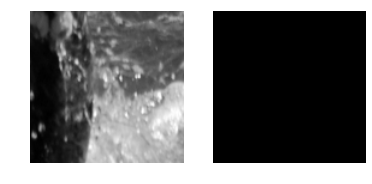

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_patch(patch):
    fig, axes = plt.subplots(1,2)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.gray()
    axes[0].imshow(patch[0])
    axes[1].imshow(patch[1][:,:,0]) # blue: background, green: whale, red: edge
    print(patch[0].shape)
    
display_patch(random.choice(pos_all))

In [7]:
len(neg_all)

30818

In [8]:
all_patches = list(chain(pos_all, neg_all))
all_patch_imgs, all_patch_labels = zip(*all_patches)
all_patch_imgs = np.stack(all_patch_imgs, axis=0)
all_patch_labels = np.stack(all_patch_labels, axis=0)
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

patch_imgs, patch_labels = shuffle(all_patch_imgs, all_patch_labels)
train_patch_imgs, test_patch_imgs, train_patch_labels, test_patch_labels = train_test_split(patch_imgs, 
                                                                                            patch_labels)
train_patch_imgs, val_patch_imgs, train_patch_labels, val_patch_labels = train_test_split(train_patch_imgs, 
                                                                                          train_patch_labels)
print(train_patch_imgs.shape)
print(train_patch_labels.shape)

(35095, 128, 128)
(35095, 128, 128, 2)


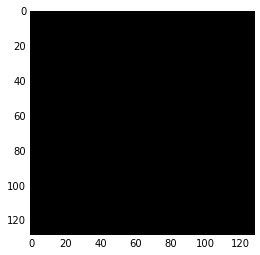

In [9]:
plt.imshow(np.transpose(train_patch_labels.swapaxes(1,3),(0,1,3,2))[0,0,:,:])

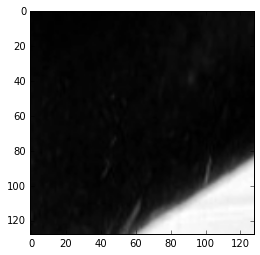

In [10]:
plt.imshow(train_patch_imgs[0])

1645

In [11]:
from train_utils import save_dataset
saveto = 'fbannot_te_128'
save_dataset(join(dataset_loc,'Flukes/patches/%s' % saveto),
             (train_patch_imgs, train_patch_labels),
             (val_patch_imgs, val_patch_labels),
             (test_patch_imgs, test_patch_labels), grey=True)

Took 1.80 seconds


In [12]:
saveto = 'TEST_fbannot_te_128'
upto = 64
save_dataset(join(dataset_loc,'Flukes/patches/%s' % saveto),
             (train_patch_imgs[:upto], train_patch_labels[:upto]),
             (val_patch_imgs[:upto], val_patch_labels[:upto]),
             (test_patch_imgs[:upto], test_patch_labels[:upto]), grey=True)

Took 0.01 seconds


[util_io] * load_cPkl(u'.../fbannot_te_128/train.pkl')


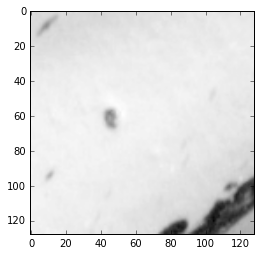

In [17]:
plt.imshow(ut.load_cPkl(join(join(dataset_loc,'Flukes/patches/%s' % 'fbannot_te_128','train.pkl')))[0][200])